In [117]:
%matplotlib inline

import numpy as np
import scipy.stats as stats
import os
from copy import deepcopy

from scipy.special import gammaln
from matplotlib import pyplot as plt

import delfi.generator as dg
import delfi.distribution as dd
from delfi.utils.viz import plot_pdf
import delfi.inference as infer
from delfi.summarystats.Identity import Identity

from snl.util.plot import plot_hist_marginals
from lfimodels.snl_exps.util import  save_results_byname, load_results_byname
from lfimodels.rockpaperscissors.rps_sde import rps_sde

model_id = 'rps'
save_path = 'results/' + model_id

seed = 4200

L = 100  # image rows/columns
duration = 100.0
dt = 1.0

nseeds = 20

use_maf = False

In [118]:
# simulation setup
setup_opts = {
    'n_bypass': 0,
    'filter_sizes': [3,3,3,3, 2, 2],
    'n_filters':    (8,8,8,16,32,32),
    'pool_sizes':   [1,3,2,2, 2, 1],
    'n_hiddens': [50, 50],
    'reg_lambda': 0.01,
    'pilot_samples': 0,  # values are already between 0 and 1
    'verbose': True,
    'prior_norm': False,  # turn off till we've fixed the active trainer. good for uniform priors etc.
    'init_norm': False,
    'input_shape': (3,L,L),
    'verbose': True,
}
if use_maf:
    setup_opts.update(dict(density='maf', maf_mode='random', n_mades=5, maf_actfun='tanh', batch_norm=False))
else:
    setup_opts.update(dict(density='mog', n_components=1))                 

run_opts = {
    'n_train': 1000,
    'n_rounds': 10,
    'minibatch': 100,
    'epochs': 2000,
    'moo': 'resample',
    'proposal': 'discrete',
    'n_null': None,
    'train_on_all': True,
    'max_norm': 0.1,
    'val_frac': 0.1,
    'silent_fail': False,
}

In [124]:
# define a function for showing simulation results as images
def showsim(s_rgb, L=100, **kwargs):
    if 'interpolation' not in kwargs.keys():
        kwargs['interpolation'] = 'None'
    s_ryb = s_rgb.copy().reshape(3, L, L)
    s_ryb[0] = np.minimum(1.0, s_ryb[0] + s_ryb[1])
    imobj = plt.imshow(np.moveaxis(s_ryb, 0, -1), **kwargs)
    plt.gca().axis('off')
    return imobj

In [ ]:
def init_all(seed, pars_true=None, infobj=infer.SNPEC, svi=False):
    p = dd.Uniform(lower=np.array([-1, -1, -6], dtype=float), 
                   upper=np.array([1, 1, -5], dtype=float), seed=seed)
    n_cores = 8    
    mlist = [rps_sde(dt=dt, duration=duration, L=L, seed=seed + 100 + i) for i in range(n_cores)]
    g = dg.MPGenerator(models=mlist, prior=p, summary=Identity(seed=seed+2), seed=seed+3)
    
    if pars_true is None:
        pars_true = g.prior.gen(1).reshape(-1)
    #obs = g.model.gen_single(pars_true)
    obs = g.models[0].gen_single(pars_true)
    obs_stats = g.summary.calc([obs])
    
    if setup_opts['density'] == 'mog':
        setup_opts['svi'] = svi
    
    inf = infobj(generator=g, obs=obs_stats, seed=seed+4, **setup_opts)
    
    return g, pars_true, obs, obs_stats, inf

In [ ]:
pars_true = np.array([-0.5, 0.5, -5.25])

g, pars_true, obs, obs_stats, inf = init_all(seed, pars_true=pars_true)

showsim(obs_stats)

In [ ]:
# print the network structure. "None" indicates the batch dimension
for s in inf.network.layer:
    if s.startswith('mixture'):
        continue
    print('{0}: {1}'.format(s, inf.network.layer[s].output_shape))

In [ ]:
log, trn_data, posteriors = inf.run(**run_opts)

In [ ]:
fig_conv = plt.figure(figsize=(8, 8))
for r in range(run_opts['n_rounds']):
    plt.subplot(run_opts['n_rounds'], 1, r + 1)
    plt.plot(log[r]['loss'],'b',label='training loss')
    plt.plot(log[r]['val_loss_iter'], log[r]['val_loss'], 'm', label='validation loss')
    plt.legend()

In [ ]:
plot_hist_marginals(posteriors[-1].gen(1000), lims=np.vstack((g.prior.lower, g.prior.upper)).T, 
                            gt=pars_true.flatten(), rasterized=False)

In [ ]:
labels_params = ['$\log_{10}(\mu)$', '$\log_{10}(\sigma)$', '$\log_{10}(D)$'] 
# all pairwise marginals of fitted posterior
fig_posterior, _ = plot_pdf(posteriors[-1], lims=[[-1, 1], [-1, 1], [-7, -5]], gt=pars_true.reshape(-1), figsize=(8, 8), resolution=100,
                  labels_params=labels_params, ticks=True)

In [ ]:
fig_nlogptrue = plt.figure()

nsim = (np.arange(run_opts['n_rounds']) + 1.0) * run_opts['n_train']

plt.semilogx(nsim, [-pp.eval(pars_true.reshape(1, -1), log=True) for pp in posteriors],'.-')
plt.ylabel('-log p(true parameters)')
plt.xlabel('Number of simulations (log scale)')

In [ ]:
# draw samples from the prior and posterior
n_samples = 5

g.proposal = None
x_prior = g.gen(n_samples)[1]
x_posterior = np.stack([y[0]['data'] for y in g.model.gen(posteriors[-1].gen(n_samples))], axis=0)

In [ ]:
fig_samples = plt.figure(figsize=(8, 8))
plt.subplot(3, n_samples, 1)
showsim(obs_stats)
plt.title('Observed data')
for i in range(n_samples):
    plt.subplot(3, n_samples, n_samples + i + 1)
    showsim(x_posterior[i])
    if i == 0:
        plt.title('Posterior samples')
    plt.subplot(3, n_samples, 2 * n_samples + i + 1)
    showsim(x_prior[i])
    if i == 0:
        plt.title('Prior samples')

In [ ]:
fig_posterior.savefig('rps_posterior.pdf')
fig_samples.savefig('rps_samples.pdf')
fig_nlogptrue.savefig('rps_nlogptrue.pdf')

!pdftk rps_posterior.pdf rps_samples.pdf rps_nlogptrue.pdf cat output rps.pdf
!rm rps_posterior.pdf
!rm rps_samples.pdf
!rm rps_nlogptrue.pdf

In [ ]:
seeds = seed + np.arange(nseeds) * 20

In [ ]:
# run multiple seeds with SNPEC discrete MDN
for s in seeds:
    _, pt, raw_data, stats, nextinf = init_all(s)  # samples observed data from the marginal (i.e. with parameters from the prior)
    ll, _, pp = nextinf.run(**run_opts)
    
    exp_id = 'rps_' + setup_opts['density'] + '_' + str(s)
    save_results_byname(logs=ll, posteriors=pp, raw_data=raw_data, pars_true=pt, seed=s,
                        setup_opts=setup_opts, run_opts=run_opts, exp_id=exp_id, path=save_path)

In [ ]:
run_opts_SNPEAB = {
    'n_train': 1000,
    'n_rounds': 10,
    'minibatch': 100,
    'epochs': 2000,
    'max_norm': 0.1,
    'val_frac': 0.1,
}

In [ ]:
# run multiple seeds with SNPEA MDN
for s in seeds:
    
    _, pt, raw_data, stats, nextinf = init_all(s, infobj=infer.CDELFI)  # samples observed data from the marginal (i.e. with parameters from the prior)
    ll, _, pp = nextinf.run(**run_opts_SNPEAB)
    
    exp_id = 'rps_' + setup_opts['density'] + '_' + str(s) + '_A'
    save_results_byname(logs=ll, posteriors=pp, raw_data=raw_data, pars_true=pt, seed=s,
                        setup_opts=setup_opts, run_opts=run_opts, exp_id=exp_id, path=save_path)

In [ ]:
# run multiple seeds with SNPEB MDN
for s in seeds:
    
    _, pt, raw_data, stats, nextinf = init_all(s, infobj=infer.SNPE, svi=True)  # samples observed data from the marginal (i.e. with parameters from the prior)
    ll, _, pp = nextinf.run(**run_opts_SNPEAB)
    
    exp_id = 'rps_' + setup_opts['density'] + '_' + str(s) + '_B'
    save_results_byname(logs=ll, posteriors=pp, raw_data=raw_data, pars_true=pt, seed=s,
                        setup_opts=setup_opts, run_opts=run_opts, exp_id=exp_id, path=save_path)

In [108]:
#load results
subdirs = os.listdir(save_path)
exp_ids, exp_ids_A, exp_ids_B = [], [], []
for d in subdirs:
    if not d.startswith('rps_'):
        continue
    if d.endswith('_A'):
        exp_ids_A.append(d)
    elif d.endswith('_B'):
        exp_ids_B.append(d)
    else:
        exp_ids.append(d)
        
posteriors_seeds, pars_true_seeds, raw_data_seeds = [], [], []
for exp_id in exp_ids:
    pp, load_vars = load_results_byname(exp_id, path=save_path)
    posteriors_seeds.append(pp)
    pars_true_seeds.append(np.array(load_vars['pars_true']))
    raw_data_seeds.append(load_vars['raw_data']['data'])
Pmat = np.array([[-pp.eval(pt.reshape(1, -1), log=True)[0] for pp in P] for P, pt in zip (posteriors_seeds, pars_true_seeds)]).T
    
posteriors_seeds_A, pars_true_seeds_A = [], []
for exp_id in exp_ids_A:
    pp, load_vars = load_results_byname(exp_id, path=save_path)
    pp_ok = []
    for nextp in pp:
        if nextp is None:
            pp_ok.append(pp_ok[-1])
        else:
            pp_ok.append(nextp)
    posteriors_seeds_A.append(pp_ok)
    pars_true_seeds_A.append(np.array(load_vars['pars_true']))
Pmat_A = np.array([[-pp.eval(pt.reshape(1, -1), log=True)[0] for pp in P] for P, pt in zip (posteriors_seeds_A, pars_true_seeds_A)]).T

posteriors_seeds_B, pars_true_seeds_B = [], []
for exp_id in exp_ids_B:
    pp, load_vars = load_results_byname(exp_id, path=save_path)
    posteriors_seeds_B.append(pp)
    pars_true_seeds_B.append(np.array(load_vars['pars_true']))
Pmat_B = np.array([[-pp.eval(pt.reshape(1, -1), log=True)[0] for pp in P] for P, pt in zip (posteriors_seeds_B, pars_true_seeds_B)]).T

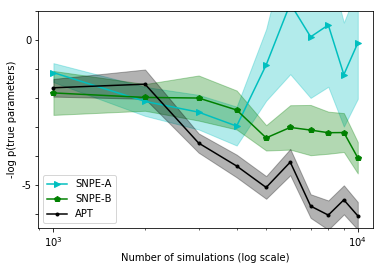

In [114]:
plotfun = plt.semilogx

nsim = (np.arange(run_opts['n_rounds']) + 1.0) * run_opts['n_train']
fig_nlogptrue = plt.figure()


sem = Pmat.std(axis=1) / np.sqrt(Pmat.shape[1] - 1)
meanlog = Pmat.mean(axis=1)
sem_A = Pmat_A.std(axis=1) / np.sqrt(Pmat_A.shape[1] - 1)
meanlog_A = Pmat_A.mean(axis=1)
sem_B = Pmat_B.std(axis=1) / np.sqrt(Pmat_B.shape[1] - 1)
meanlog_B = Pmat_B.mean(axis=1)

plt.fill_between(nsim, meanlog_A-sem_A, meanlog_A+sem_A, color='c', alpha=0.3)
plt.fill_between(nsim, meanlog_B-sem_B, meanlog_B+sem_B, color='g', alpha=0.3)
plt.fill_between(nsim, meanlog-sem, meanlog+sem, color='k', alpha=0.3)
hA = plotfun(nsim, Pmat_A.mean(axis=1),'c>-', label='SNPE-A')
hB = plotfun(nsim, Pmat_B.mean(axis=1),'gp-', label='SNPE-B')
h = plotfun(nsim, Pmat.mean(axis=1),'k.-', label='APT')

plt.ylim((-6.5, 1))

plt.ylabel('-log p(true parameters)')
plt.xlabel('Number of simulations (log scale)')
plt.legend(loc='lower left')

ax = plt.gca()
yt_show = [-5, 0]
YTL = ax.get_yticks().tolist()
for i in range(len(YTL)):
    if YTL[i] not in yt_show:
        YTL[i] = ''
    else:
        YTL[i] = [z for z in yt_show if z == YTL[i]][0]
ax.set_yticklabels(YTL)
plt.show()

In [123]:
# define a setup for a 1K x 1K image
L_big = 1000
pars_true_big = np.array([-0.5, 0.5, -5.25])
svi = False
dt_big = 0.1

setup_opts_big = deepcopy(setup_opts)
setup_opts_big.update(dict(
    filter_sizes=[3,3,3,3, 2, 2],
    n_filters=   (8,8,8,16,32,32),
    pool_sizes=  [1,3,2,2, 2, 1],
    input_shape= (3, L_big, L_big)
    ))

p = dd.Uniform(lower=np.array([-1, -1, -6], dtype=float), 
               upper=np.array([1, 1, -5], dtype=float), seed=seed)
n_cores = 8    
mlist_big = [rps_sde(dt=dt_big, duration=duration, L=L_big, seed=seed + 100 + i) for i in range(n_cores)]
g_big = dg.MPGenerator(models=mlist_big, prior=p, summary=Identity(seed=seed+2), seed=seed+3)
obs = g_big.models[0].gen_single(pars_true_big)
obs_stats = g_big.summary.calc([obs])
    
if setup_opts_big['density'] == 'mog':
    setup_opts_big['svi'] = svi
    
inf_big = infobj(generator=g_big, obs=obs_stats, seed=seed+4, **setup_opts_big)

NameError: name 'infobj' is not defined

In [ ]:
# print the network structure. "None" indicates the batch dimension
for s in inf_big.network.layer:
    if s.startswith('mixture'):
        continue
    print('{0}: {1}'.format(s, inf.network.layer[s].output_shape))